# Case Técnico – iFood  
### **Notebook de Processamento, Análise A/B, Segmentação e Viabilidade Financeira**

Autor: **Daniel Leite**  
Data: 2025  
Repositório GitHub: _(https://github.com/danielmelo2025/Case-iFood)_

---

Este notebook contém:

1. **ETL completo**  
2. **Preparação das bases (orders, consumers, restaurants, ab_ref)**  
3. **Análise estatística do teste A/B**  
4. **Segmentação RFM**  
5. **Análise por segmentos x A/B**  
6. **Simulação de viabilidade financeira (Monte Carlo)**  
7. **Recomendações e próximos passos**

---

In [1]:
# ========================================
# Imports
# ========================================
import pandas as pd
import numpy as np
import json
import gzip
import tarfile
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

pd.set_option("display.max_columns", None)

# 1. Download dos arquivos  
Os dados originais estão compactados (`.gz` e `.tar.gz`).  
Vamos baixá-los localmente.


In [3]:
# ========================================
# Função de Download
# ========================================
def download_to_disk(url, filename):
    print(f"Baixando {filename} ...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024*1024):
                f.write(chunk)
    print(f"Arquivo salvo em: {filename}")

In [4]:
# ========================================
# URLs oficiais do case
# ========================================
url_orders = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz"
url_consumers = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz"
url_restaurants = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz"
url_ab = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"

# Downloads
download_to_disk(url_orders, "order.json.gz")
download_to_disk(url_consumers, "consumer.csv.gz")
download_to_disk(url_restaurants, "restaurant.csv.gz")
download_to_disk(url_ab, "ab_test_ref.tar.gz")

Baixando order.json.gz ...
Arquivo salvo em: order.json.gz
Baixando consumer.csv.gz ...
Arquivo salvo em: consumer.csv.gz
Baixando restaurant.csv.gz ...
Arquivo salvo em: restaurant.csv.gz
Baixando ab_test_ref.tar.gz ...
Arquivo salvo em: ab_test_ref.tar.gz


# 2. Leitura e ETL das bases  
## 2.1 Leitura otimizada do `order.json.gz`  
Usamos leitura em *chunks* para não estourar memória.

In [5]:
# ========================================
# Leitura otimizada do orders.json.gz
# ========================================
def read_orders_in_chunks(filepath, chunksize=200_000, usecols=None):
    with gzip.open(filepath, 'rt') as f:
        for chunk in pd.read_json(f, lines=True, chunksize=chunksize):
            if usecols:
                chunk = chunk[usecols]
            yield chunk

orders_usecols = [
    'cpf', 'customer_id', 'delivery_address_city', 'delivery_address_country',
    'delivery_address_district','delivery_address_state', 'merchant_id',
    'merchant_timezone', 'order_created_at', 'order_id',
    'order_scheduled', 'order_total_amount', 'origin_platform',
    'order_scheduled_date'
]

orders_list = []

for chunk in read_orders_in_chunks(
        "/content/order.json.gz",
        chunksize=150_000,
        usecols=orders_usecols):

    chunk["order_created_at"] = pd.to_datetime(chunk["order_created_at"])
    orders_list.append(chunk)

orders = pd.concat(orders_list, ignore_index=True)

orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670826 entries, 0 to 3670825
Data columns (total 14 columns):
 #   Column                     Dtype              
---  ------                     -----              
 0   cpf                        int64              
 1   customer_id                object             
 2   delivery_address_city      object             
 3   delivery_address_country   object             
 4   delivery_address_district  object             
 5   delivery_address_state     object             
 6   merchant_id                object             
 7   merchant_timezone          object             
 8   order_created_at           datetime64[ns, UTC]
 9   order_id                   object             
 10  order_scheduled            bool               
 11  order_total_amount         float64            
 12  origin_platform            object             
 13  order_scheduled_date       object             
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), in

,cpf,customer_id,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_state,merchant_id,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
0,80532101763,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,FRANCA,BR,JARDIM ESPRAIADO,SP,a992a079a651e699d9149423761df2427c0e3af0a2a1b5...,America/Sao_Paulo,2019-01-17 22:50:06+00:00,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,False,46.0,ANDROID,NaN
1,43352103961,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,SANTOS,BR,CAMPO GRANDE,SP,5152f28ee0518b8803ccf0a4096eb2ff8b81e9491861c9...,America/Sao_Paulo,2019-01-17 17:51:26+00:00,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,False,104.5,ANDROID,NaN
2,38650991217,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,GUARULHOS,BR,JARDIM ROSSI,SP,b6096419455c35d06105a5ef0d25c51f9dd40e1e99ac33...,America/Sao_Paulo,2019-01-17 22:53:47+00:00,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,False,35.0,IOS,NaN
3,63579726866,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,SAO PAULO,BR,PARQUE SAO JORGE,SP,082bfdcdf6ccdc343e3c4d25ee376b5b6ca7e96ad8b04e...,America/Sao_Paulo,2019-01-17 23:56:53+00:00,b4df94142d21354611247da9ca94f870c09b93989b531a...,False,40.8,IOS,NaN
4,90617788806,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,VITORIA,BR,JARDIM CAMBURI,ES,d7adb764bac29ccb77fb8f746ffbd531bf05ec30a7e130...,America/Sao_Paulo,2019-01-17 23:40:53+00:00,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,False,48.5,ANDROID,NaN


## 2.2 Leitura das demais bases (mais leves)

In [6]:
consumers = pd.read_csv("/content/consumer.csv.gz", compression="gzip")
restaurants = pd.read_csv("/content/restaurant.csv.gz", compression="gzip")

## 2.3 Leitura da base A/B (`ab_test_ref.tar.gz`)  

In [7]:
def load_ab_ref_from_tar(tar_path):
    with tarfile.open(tar_path, "r:gz") as tar:

        members = [
            m for m in tar.getmembers()
            if m.name.endswith(".csv") and not m.name.startswith("._")
        ]

        if not members:
            raise ValueError("Nenhum CSV válido encontrado dentro do TAR.")

        member = members[0]
        print(f"Lendo arquivo real: {member.name}")

        f = tar.extractfile(member)
        raw = f.read()

        for enc in ["utf-8", "latin1", "cp1252"]:
            try:
                df = pd.read_csv(BytesIO(raw), encoding=enc)
                print(f"Lido com encoding: {enc}")
                return df
            except:
                pass

        raise ValueError("Não foi possível ler com encodings testados.")

ab_ref = load_ab_ref_from_tar("/content/ab_test_ref.tar.gz")
ab_ref.head()

Lendo arquivo real: ab_test_ref.csv
Lido com encoding: utf-8


,customer_id,is_target
0,755e1fa18f25caec5edffb188b13fd844b2af8cf5adedc...,target
1,b821aa8372b8e5b82cdc283742757df8c45eecdd72adf4...,control
2,d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc0...,control
3,6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c...,target
4,dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f...,control


# 3. Preparação das Bases



In [8]:
def prepare_restaurants(restaurants):
    df = restaurants.rename(columns={'id': 'restaurant_id'})
    df = df.drop_duplicates(subset=['restaurant_id'])
    df = df[['restaurant_id','merchant_city','merchant_state','enabled','price_range',
             'average_ticket','delivery_time','minimum_order_value','merchant_zip_code',
             'merchant_country','created_at']]
    df['enabled'] = df['enabled'].astype(bool)
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    return df

def prepare_consumers(consumers):
    df = consumers.rename(columns={'customerid': 'customer_id'})
    df = df.drop_duplicates(subset=['customer_id'])
    df['active'] = df.get('active', pd.Series([True]*df.shape[0])).astype(bool)
    if 'createdat' in df.columns:
        df['createdat'] = pd.to_datetime(df['createdat'], errors='coerce')
    return df

def prepare_orders(orders):
    df = orders.copy()
    df['order_created_at'] = pd.to_datetime(df['order_created_at'], errors='coerce')
    df = df.rename(columns={'merchant_id': 'restaurant_id'})
    df = df[['order_id','customer_id','restaurant_id','order_created_at','order_total_amount','order_scheduled']]
    df = df.dropna(subset=['order_id','customer_id','restaurant_id','order_created_at'])
    return df

def prepare_ab_ref(ab_ref):
    df = ab_ref.rename(columns={'is_target': 'ab_group'})
    df['ab_group'] = df['ab_group'].astype('category')
    df = df.drop_duplicates(subset=['customer_id'])
    return df

In [9]:
restaurants = prepare_restaurants(restaurants)
consumers = prepare_consumers(consumers)
orders = prepare_orders(orders)
ab_ref = prepare_ab_ref(ab_ref)

In [10]:
# Base final unificada
orders_consumers = orders.merge(consumers, on='customer_id', how='left')
orders_consumers_restaurants = orders_consumers.merge(restaurants, on='restaurant_id', how='left')
final_df = orders_consumers_restaurants.merge(ab_ref, on='customer_id', how='left')

final_df.head()

,order_id,customer_id,restaurant_id,order_created_at,order_total_amount,order_scheduled,language,created_at_x,active,customer_name,customer_phone_area,customer_phone_number,merchant_city,merchant_state,enabled,price_range,average_ticket,delivery_time,minimum_order_value,merchant_zip_code,merchant_country,created_at_y,ab_group
0,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,a992a079a651e699d9149423761df2427c0e3af0a2a1b5...,2019-01-17 22:50:06+00:00,46.0,False,pt-br,2018-04-05T23:45:51.591Z,True,GUSTAVO,12.0,599105694.0,FRANCA,SP,False,2,40.0,40.0,10.0,14401,BR,2017-01-23 12:42:34.105000+00:00,control
1,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,5152f28ee0518b8803ccf0a4096eb2ff8b81e9491861c9...,2019-01-17 17:51:26+00:00,104.5,False,pt-br,2018-02-04T00:07:47.551Z,True,MICHELLE,39.0,615855072.0,SANTOS,SP,True,4,80.0,0.0,20.0,11075,BR,2017-01-20 13:15:38.463000+00:00,control
2,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,b6096419455c35d06105a5ef0d25c51f9dd40e1e99ac33...,2019-01-17 22:53:47+00:00,35.0,False,pt-br,2018-03-03T23:59:10.670Z,True,VICTOR,76.0,58025853.0,SAO PAULO,SP,True,2,60.0,0.0,20.0,22880,BR,2017-01-20 13:14:13.845000+00:00,control
3,b4df94142d21354611247da9ca94f870c09b93989b531a...,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,082bfdcdf6ccdc343e3c4d25ee376b5b6ca7e96ad8b04e...,2019-01-17 23:56:53+00:00,40.8,False,pt-br,2018-01-05T22:17:42.554Z,True,ANNIE,58.0,841327083.0,SAO PAULO,SP,True,4,60.0,0.0,10.0,33180,BR,2017-01-20 13:13:30.130000+00:00,control
4,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,d7adb764bac29ccb77fb8f746ffbd531bf05ec30a7e130...,2019-01-17 23:40:53+00:00,48.5,False,pt-br,2018-04-06T00:41:08.195Z,True,DANIEL,59.0,606314319.0,VITORIA,ES,True,3,60.0,0.0,20.0,29070,BR,2017-01-20 13:14:27.434000+00:00,target


# 4. Análise do Teste A/B
- Receita total por usuário  
- Número de pedidos  
- Ticket médio  
- Significância estatística  
- Intervalos de confiança

## 4.1 Receita total por usuário  

In [11]:
# Criar dataset de métricas por usuário
user_metrics = final_df.groupby(['ab_group', 'customer_id']).agg(
    total_revenue=('order_total_amount', 'sum'),
    total_orders=('order_id', 'nunique')
).reset_index()

# Ticket médio
user_metrics['avg_ticket'] = np.where(
    user_metrics['total_orders'] > 0,
    user_metrics['total_revenue'] / user_metrics['total_orders'],
    np.nan
)

# Medidas resumo por grupo
summary = user_metrics.groupby('ab_group')[['total_revenue', 'total_orders', 'avg_ticket']].describe()
display(summary)

/tmp/ipython-input-772909597.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_metrics = final_df.groupby(['ab_group', 'customer_id']).agg(
/tmp/ipython-input-772909597.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = user_metrics.groupby('ab_group')[['total_revenue', 'total_orders', 'avg_ticket']].describe()


total_revenue                                                 \
                 count        mean         std  min  25%   50%    75%   
ab_group                                                                
control       806466.0   90.607506  391.367166  0.0  0.0   0.0   87.6   
target        806466.0  126.487130  279.170153  0.0  0.0  34.0  137.8   

                   total_orders                                          \
               max        count      mean       std  min  25%  50%  75%   
ab_group                                                                  
control   280677.8     806466.0  1.253293  2.777303  0.0  0.0  0.0  1.0   
target     37302.6     806466.0  1.756648  3.276065  0.0  0.0  1.0  2.0   

                avg_ticket                                            \
            max      count       mean         std  min     25%   50%   
ab_group                                                               
control    86.0   360542.0  72.685183  243.201481  0.0  39.990  59.8   
target    157.0   445924.0  72.337597   62.870824  0.0  40.625  60.0   

                               
                75%       max  
ab_group                       
control   88.800000  140338.9  
target    88.393571   14959.6

In [12]:
# Receitas por usuário dos grupos
control_revenue = user_metrics[user_metrics['ab_group'] == 'control']['total_revenue']
target_revenue = user_metrics[user_metrics['ab_group'] == 'target']['total_revenue']

# Teste t para média independente (não assume variâncias iguais)
t_stat, p_val = stats.ttest_ind(target_revenue, control_revenue, equal_var=False)

# Médias e desvios padrões
mean_c = control_revenue.mean()
mean_t = target_revenue.mean()
std_c = control_revenue.std()
std_t = target_revenue.std()
n_c = control_revenue.count()
n_t = target_revenue.count()

# Diferença média
diff_mean = mean_t - mean_c

# Erro padrão da diferença
se_diff = np.sqrt(std_c**2/n_c + std_t**2/n_t)

# Graus de liberdade pelo método de Welch
df = (std_c**2/n_c + std_t**2/n_t)**2 / ((std_c**2/n_c)**2 / (n_c-1) + (std_t**2/n_t)**2 / (n_t-1))

# Intervalo de confiança (95%)
alpha = 0.05
t_crit = stats.t.ppf(1-alpha/2, df)
ci_lower = diff_mean - t_crit * se_diff
ci_upper = diff_mean + t_crit * se_diff

print(f"Teste t: t_stat = {t_stat:.4f}, p-value = {p_val:.4e}")
print(f"Diferença média entre grupos: {diff_mean:.2f}")
print(f"Intervalo de confiança 95% da diferença: [{ci_lower:.2f}, {ci_upper:.2f}]")

Teste t: t_stat = 67.0250, p-value = 0.0000e+00
Diferença média entre grupos: 35.88
Intervalo de confiança 95% da diferença: [34.83, 36.93]


## 4.2 Ticket Médio

In [13]:
# Verificar equilíbrio dos grupos
print(final_df['ab_group'].value_counts())

# Função para calcular KPIs
def calculate_metrics(df):
    grouped = df.groupby('ab_group')
    n_users = grouped['customer_id'].nunique()
    n_orders = grouped['order_id'].nunique()
    avg_order_value = grouped['order_total_amount'].mean()
    total_revenue = grouped['order_total_amount'].sum()
    orders_per_user = n_orders / n_users

    metrics = pd.DataFrame({
        'ab_group': n_users.index,
        'n_users': n_users.values,
        'n_orders': n_orders.values,
        'avg_order_value': avg_order_value.values,
        'orders_per_user': orders_per_user.values,
        'total_revenue': total_revenue.values
    })
    return metrics


metrics_df = calculate_metrics(final_df)
print(metrics_df)

# Teste estatístico para ticket médio
control = final_df.loc[final_df['ab_group'] == 'control', 'order_total_amount'].dropna()
target = final_df.loc[final_df['ab_group'] == 'target', 'order_total_amount'].dropna()

t_stat, p_value = stats.ttest_ind(target, control, equal_var=False)
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Calcular lift percentual
avg_control = control.mean()
avg_target = target.mean()
lift = (avg_target - avg_control) / avg_control * 100
print(f"Lift percentual no ticket médio (target vs control): {lift:.2f}%")

# Interpretação simples
if p_value < 0.05:
    print("Diferença estatisticamente significativa no ticket médio entre grupos.")
else:
    print("Não há diferença estatisticamente significativa no ticket médio.")

ab_group
target     2136745
control    1525576
Name: count, dtype: int64


/tmp/ipython-input-3836537508.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('ab_group')


  ab_group  n_users  n_orders  avg_order_value  orders_per_user  total_revenue
0  control   360542   1010738        47.897891         2.803385   7.307187e+07
1   target   445924   1416677        47.739702         3.176947   1.020076e+08
t-statistic: -1.1537
p-value: 0.2486
Lift percentual no ticket médio (target vs control): -0.33%
Não há diferença estatisticamente significativa no ticket médio.


In [14]:
def mean_ci(data, conf=0.95):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    h = std / np.sqrt(n) * stats.t.ppf((1 + conf) / 2, n - 1)
    return mean, mean - h, mean + h

# Calcular para cada grupo
avg_control, ci_control_low, ci_control_high = mean_ci(control)
avg_target, ci_target_low, ci_target_high = mean_ci(target)

print(f"Ticket médio controle: {avg_control:.2f}, IC95%: [{ci_control_low:.2f}, {ci_control_high:.2f}]")
print(f"Ticket médio target: {avg_target:.2f}, IC95%: [{ci_target_low:.2f}, {ci_target_high:.2f}]")

Ticket médio controle: 47.90, IC95%: [47.64, 48.16]
Ticket médio target: 47.74, IC95%: [47.68, 47.80]


## 4.3 Retenção

In [15]:
final_df['order_created_at'] = pd.to_datetime(final_df['order_created_at'])

final_df['order_ym'] = final_df['order_created_at'].dt.to_period('M')

# Primeiro mês de pedido por usuário
first_order = final_df.groupby('customer_id')['order_ym'].min().reset_index()
first_order = first_order.rename(columns={'order_ym': 'first_order_ym'})

# Juntar info de primeiro pedido
df = final_df.merge(first_order, on='customer_id')

# Criar coluna com meses desde o primeiro pedido
df['months_since_first'] = (df['order_ym'] - df['first_order_ym']).apply(lambda x: x.n)

# Para cada grupo A/B calcular % de usuários ativos em cada mês
retention = df.groupby(['ab_group', 'months_since_first'])['customer_id'].nunique().reset_index()

# Total de usuários que fizeram primeiro pedido no grupo, para base de cálculo (%)
total_users = first_order.merge(ab_ref, on='customer_id').groupby('ab_group')['customer_id'].nunique().reset_index(name='total_users')

# Juntar totais para calcular taxa de retenção
retention = retention.merge(total_users, on='ab_group')
retention['retention_rate'] = retention['customer_id'] / retention['total_users']

print(retention.head(20))

/tmp/ipython-input-1840202249.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  final_df['order_ym'] = final_df['order_created_at'].dt.to_period('M')
/tmp/ipython-input-1840202249.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention = df.groupby(['ab_group', 'months_since_first'])['customer_id'].nunique().reset_index()
/tmp/ipython-input-1840202249.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_users = first_order.merge(ab_ref, on='customer_id').groupby('ab_group')['customer_id'].nunique().reset_index(name='total_users')


  ab_group  months_since_first  customer_id  total_users  retention_rate
0  control                   0       360542       360542        1.000000
1  control                   1       241546       360542        0.669952
2   target                   0       445924       445924        1.000000
3   target                   1       313049       445924        0.702023


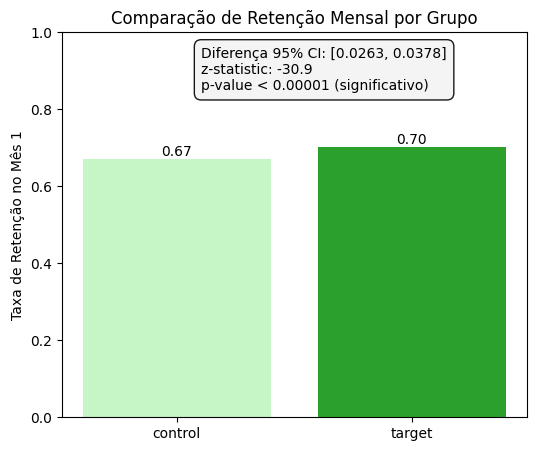

In [16]:
# Dados para o gráfico
retention_month_1 = retention[retention['months_since_first'] == 1][['ab_group', 'retention_rate']]

fig, ax = plt.subplots(figsize=(6, 5))

colors = ['#c6f5c6', '#2ca02c']  # Primeiro controle, depois target
bars = ax.bar(retention_month_1['ab_group'], retention_month_1['retention_rate'], color=colors)

ax.set_ylim(0, 1)
ax.set_ylabel('Taxa de Retenção no Mês 1')
ax.set_title('Comparação de Retenção Mensal por Grupo')

# Anotações das taxas nas barras
ax.bar_label(bars, fmt='%.2f')

# Anotar intervalo de confiança e p-valor no gráfico na posição desejada
textstr = '\n'.join((
    'Diferença 95% CI: [0.0263, 0.0378]',
    'z-statistic: -30.9',
    'p-value < 0.00001 (significativo)'
))
ax.text(0.3, 0.85, textstr, transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#f3f3f3', alpha=0.9))

plt.show()

In [17]:
retention_month_1

,ab_group,retention_rate
1,control,0.669952
3,target,0.702023


# 5 Viabilidade financeira da campanha (Simulação Monte Carlo)

Premissas:
- Número de usuários target ≈ 806.466 (do experimento)
- Custo unitário médio do cupom: média R$10, desvio R$3
- Receita incremental média por usuário: média R$35, desvio R$10
- Custo operacional: média 15% do custo, desvio 5%

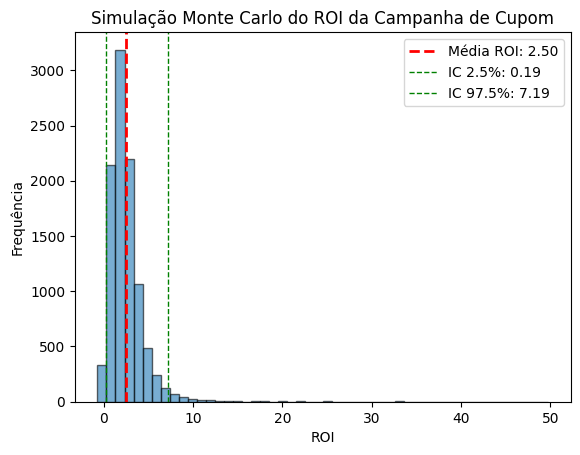

Média do ROI: 2.50
Desvio padrão do ROI: 2.34
Intervalo de confiança 95% do ROI: [0.19, 7.19]


In [18]:
# Número de usuários alvo
n_users_target = 806466

# Semente para reprodutibilidade
np.random.seed(42)

# Distribuições para os parâmetros (normal truncada para evitar valores negativos)
custo_unit = np.clip(np.random.normal(10, 3, 10000), 1, None)  # custo médio 10, desvio 3
receita_inc = np.clip(np.random.normal(35, 10, 10000), 5, None)  # receita incremental média 35, desvio 10
custo_op = np.clip(np.random.normal(0.15, 0.05, 10000), 0, 1)  # custo operacional média 15%, desvio 5%

# Simulação de Monte Carlo do ROI
roi_sim = []
for i in range(10000):
    custo_total = n_users_target * custo_unit[i]
    custo_operacional = custo_total * custo_op[i]
    receita_incremental = n_users_target * receita_inc[i]
    investimento_total = custo_total + custo_operacional
    roi = (receita_incremental - investimento_total) / investimento_total
    roi_sim.append(roi)

roi_sim = np.array(roi_sim)

# Estatísticas
roi_mean = roi_sim.mean()
roi_std = roi_sim.std()
roi_ci_low = np.percentile(roi_sim, 2.5)
roi_ci_high = np.percentile(roi_sim, 97.5)

# Visualização do resultado
plt.hist(roi_sim, bins=50, edgecolor='k', alpha=0.6)
plt.axvline(roi_mean, color='r', linestyle='dashed', linewidth=2, label=f'Média ROI: {roi_mean:.2f}')
plt.axvline(roi_ci_low, color='g', linestyle='dashed', linewidth=1, label=f'IC 2.5%: {roi_ci_low:.2f}')
plt.axvline(roi_ci_high, color='g', linestyle='dashed', linewidth=1, label=f'IC 97.5%: {roi_ci_high:.2f}')
plt.title('Simulação Monte Carlo do ROI da Campanha de Cupom')
plt.xlabel('ROI')
plt.ylabel('Frequência')
plt.legend()
plt.show()

print(f'Média do ROI: {roi_mean:.2f}')
print(f'Desvio padrão do ROI: {roi_std:.2f}')
print(f'Intervalo de confiança 95% do ROI: [{roi_ci_low:.2f}, {roi_ci_high:.2f}]')

In [19]:
n_users_target = 806466

cenarios = {
    'Pessimista': {'custo_unit': 15, 'receita_inc': 20, 'custo_op': 0.20},
    'Base': {'custo_unit': 10, 'receita_inc': 35, 'custo_op': 0.15},
    'Otimista': {'custo_unit': 7, 'receita_inc': 50, 'custo_op': 0.10}
}

results = []

for nome, params in cenarios.items():
    custo_total = n_users_target * params['custo_unit']
    custo_operacional = custo_total * params['custo_op']
    receita_incremental = n_users_target * params['receita_inc']
    investimento_total = custo_total + custo_operacional
    roi = (receita_incremental - investimento_total) / investimento_total
    results.append({
        'Cenário': nome,
        'Receita Incremental Total (R$)': receita_incremental,
        'Custo Total (cupom + operacional) (R$)': investimento_total,
        'ROI': roi
    })

results_df = pd.DataFrame(results)
results_df['ROI %'] = results_df['ROI'] * 100
results_df['Receita Incremental Total (R$)'] = results_df['Receita Incremental Total (R$)'].map('{:,.2f}'.format)
results_df['Custo Total (cupom + operacional) (R$)'] = results_df['Custo Total (cupom + operacional) (R$)'].map('{:,.2f}'.format)
results_df['ROI %'] = results_df['ROI %'].map('{:.2f}%'.format)
results_df.drop(columns=['ROI'], inplace=True)

display(results_df)

,Cenário,Receita Incremental Total (R$),Custo Total (cupom + operacional) (R$),ROI %
0,Pessimista,"16,129,320.00","14,516,388.00",11.11%
1,Base,"28,226,310.00","9,274,359.00",204.35%
2,Otimista,"40,323,300.00","6,209,788.20",549.35%


# 6 Segmentação RFM

In [20]:
# Garantir formato de data
orders["order_created_at"] = pd.to_datetime(orders["order_created_at"])

# Consolidar métricas por cliente
rfm_base = (
    orders.groupby("customer_id")
    .agg(
        last_order_date = ("order_created_at", "max"),
        order_count     = ("order_id", "count"),
        total_spent     = ("order_total_amount", "sum")
    )
    .reset_index()
)

rfm_base.head()

,customer_id,last_order_date,order_count,total_spent
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,2019-01-25 23:26:38+00:00,10,373.0
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,2019-01-29 00:14:08+00:00,5,293.8
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,2019-01-29 17:47:06+00:00,4,137.3
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,2019-01-14 23:41:56+00:00,2,177.6
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,2019-01-24 22:16:23+00:00,5,533.1


In [21]:
def calculate_rfm(df, ref_date, n_bins=4):
    df = df.copy()

    # ----------------------------
    # Calcular recência
    # ----------------------------
    df['last_order_date'] = pd.to_datetime(df['last_order_date'])
    df['recency'] = (ref_date - df['last_order_date']).dt.days

    def safe_qcut(series, q):
        # 1) Tenta qcut normal
        try:
            return pd.qcut(series, q, labels=False, duplicates='drop') + 1
        except:
            pass

        # 2) Tenta qcut com rank
        try:
            ranked = series.rank(method='first')
            return pd.qcut(ranked, q, labels=False, duplicates='drop') + 1
        except:
            pass

        # 3) Tenta cut
        try:
            return pd.cut(series, q, labels=False) + 1
        except:
            pass

        # 4) Fallback: tudo score 1
        return pd.Series([1] * len(series), index=series.index)

    # ----------------------------
    # Calcular scores
    # ----------------------------
    df['recency_score']   = safe_qcut(df['recency'], n_bins)
    df['frequency_score'] = safe_qcut(df['order_count'], n_bins)
    df['monetary_score']  = safe_qcut(df['total_spent'], n_bins)

    # Recência invertida (poucos dias = score maior)
    df['recency_score'] = (n_bins + 1) - df['recency_score']

    # ----------------------------
    # Criar segmentos
    # ----------------------------
    def assign_segment(row):
        r, f, m = row['recency_score'], row['frequency_score'], row['monetary_score']

        if r >= n_bins and f >= n_bins and m >= n_bins-1:
            return "heavy_user"
        if r >= n_bins-1 and f <= 2:
            return "leve_engajado"
        if m == n_bins:
            return "high_spender"
        if 2 <= r < n_bins-1:
            return "adormecido"
        if r == 1:
            return "churnado"

        return "outros"

    df['segmento'] = df.apply(assign_segment, axis=1)

    return df

In [22]:
ref_date = orders["order_created_at"].max()

rfm_df = calculate_rfm(rfm_base, ref_date)

In [23]:
rfm_df["segmento"].value_counts()

,count
segmento,
leve_engajado,243080
churnado,182761
adormecido,176607
high_spender,175942
outros,28076


In [24]:
rfm_df.head()

,customer_id,last_order_date,order_count,total_spent,recency,recency_score,frequency_score,monetary_score,segmento
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,2019-01-25 23:26:38+00:00,10,373.0,6,3,3,4,high_spender
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,2019-01-29 00:14:08+00:00,5,293.8,2,4,2,4,leve_engajado
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,2019-01-29 17:47:06+00:00,4,137.3,2,4,2,3,leve_engajado
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,2019-01-14 23:41:56+00:00,2,177.6,17,2,1,3,adormecido
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,2019-01-24 22:16:23+00:00,5,533.1,7,3,2,4,leve_engajado


In [25]:
segment_profile = (
    rfm_df.groupby("segmento")
    .agg(
        usuarios = ("customer_id", "nunique"),
        recencia_media = ("recency", "mean"),
        freq_media = ("order_count", "mean"),
        ticket_medio = ("total_spent", "mean"),
        gasto_total = ("total_spent", "sum"),
        recencia_mediana = ("recency", "median"),
        freq_mediana = ("order_count", "median"),
        ticket_mediana = ("total_spent", "median"),
    )
    .reset_index()
    .sort_values(by="usuarios", ascending=False)
)

segment_profile

,segmento,usuarios,recencia_media,freq_media,ticket_medio,gasto_total,recencia_mediana,freq_mediana,ticket_mediana
3,leve_engajado,243080,3.573741,2.623758,127.190860,3.091755e+07,3.0,2.0,97.800
1,churnado,182761,23.469367,1.791542,76.034425,1.389613e+07,23.0,2.0,62.590
0,adormecido,176607,12.830748,2.380353,93.994259,1.660004e+07,13.0,2.0,80.600
2,high_spender,175942,4.992128,11.786270,616.569320,1.084804e+08,3.0,9.0,454.925
4,outros,28076,3.112979,7.231336,184.687193,5.185278e+06,3.0,7.0,191.375


In [26]:
rfm_ab = rfm_df.merge(ab_ref, on="customer_id", how="left")

rfm_ab["ab_group"].value_counts(dropna=False)

,count
ab_group,
target,445924
control,360542


In [27]:
ab_seg = (
    rfm_ab.groupby(["segmento", "ab_group"])
    .agg(
        usuarios = ("customer_id", "nunique"),
        freq_media = ("order_count", "mean"),
        ticket_medio = ("total_spent", "mean"),
        recencia_media = ("recency", "mean")
    )
    .reset_index()
)

ab_seg

/tmp/ipython-input-1176639333.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_ab.groupby(["segmento", "ab_group"])


,segmento,ab_group,usuarios,freq_media,ticket_medio,recencia_media
0,adormecido,control,81653,2.272715,90.749824,12.846766
1,adormecido,target,94954,2.472913,96.784220,12.816975
2,churnado,control,87955,1.736411,74.395469,23.528145
3,churnado,target,94806,1.842689,77.554944,23.414837
4,high_spender,control,71210,11.713523,614.306489,5.065398
5,high_spender,target,104732,11.835733,618.107877,4.942310
6,leve_engajado,control,108557,2.507503,122.552605,3.594397
7,leve_engajado,target,134523,2.717572,130.933826,3.557072
8,outros,control,11167,7.248948,185.342157,3.136653
9,outros,target,16909,7.219705,184.254642,3.097345


In [28]:
pivot = ab_seg.pivot(index="segmento", columns="ab_group")

pivot["lift_freq_%"] = (
    (pivot["freq_media"]["target"] - pivot["freq_media"]["control"]) /
    pivot["freq_media"]["control"]
) * 100

pivot["lift_ticket_%"] = (
    (pivot["ticket_medio"]["target"] - pivot["ticket_medio"]["control"]) /
    pivot["ticket_medio"]["control"]
) * 100

pivot["lift_recencia_%"] = (
    (pivot["recencia_media"]["control"] - pivot["recencia_media"]["target"]) /
    pivot["recencia_media"]["control"]
) * 100

pivot

usuarios         freq_media            ticket_medio              \
ab_group       control  target    control     target      control      target   
segmento                                                                        
adormecido       81653   94954   2.272715   2.472913    90.749824   96.784220   
churnado         87955   94806   1.736411   1.842689    74.395469   77.554944   
high_spender     71210  104732  11.713523  11.835733   614.306489  618.107877   
leve_engajado   108557  134523   2.507503   2.717572   122.552605  130.933826   
outros           11167   16909   7.248948   7.219705   185.342157  184.254642   

              recencia_media            lift_freq_% lift_ticket_%  \
ab_group             control     target                             
segmento                                                            
adormecido         12.846766  12.816975    8.808767      6.649485   
churnado           23.528145  23.414837    6.120592      4.246866   
high_spender        5.065398   4.942310    1.043322      0.618810   
leve_engajado       3.594397   3.557072    8.377637      6.838877   
outros              3.136653   3.097345   -0.403401     -0.586761   

              lift_recencia_%  
ab_group                       
segmento                       
adormecido           0.231900  
churnado             0.481587  
high_spender         2.429981  
leve_engajado        1.038432  
outros               1.253184

In [29]:
resultados_teste = []

for seg in rfm_ab["segmento"].unique():
    grupo = rfm_ab[rfm_ab["segmento"] == seg]

    # target e control
    g_target = grupo[grupo["ab_group"] == "target"]
    g_control = grupo[grupo["ab_group"] == "control"]

    # testes
    t_freq, p_freq = ttest_ind(
        g_target["order_count"],
        g_control["order_count"],
        equal_var=False,
        nan_policy='omit'
    )

    t_ticket, p_ticket = ttest_ind(
        g_target["total_spent"],
        g_control["total_spent"],
        equal_var=False,
        nan_policy='omit'
    )

    t_rec, p_rec = ttest_ind(
        g_target["recency"],
        g_control["recency"],
        equal_var=False,
        nan_policy='omit'
    )

    resultados_teste.append([
        seg,
        p_freq,
        p_ticket,
        p_rec
    ])

df_testes = pd.DataFrame(resultados_teste,
                         columns=["segmento", "p_freq", "p_ticket", "p_recencia"])

df_testes

,segmento,p_freq,p_ticket,p_recencia
0,high_spender,2.988089e-03,1.322618e-01,9.389813e-06
1,leve_engajado,0.000000e+00,1.501225e-03,3.479697e-04
2,adormecido,3.556707e-191,4.157289e-108,2.334577e-02
3,churnado,1.812842e-126,5.422542e-43,1.026206e-11
4,outros,1.659127e-01,2.884464e-02,1.685655e-01


In [30]:
def interpret(p):
    return "✔️ significativo (p < 0.05)" if p < 0.05 else "❌ não significativo"

df_testes["freq_sig"] = df_testes["p_freq"].apply(interpret)
df_testes["ticket_sig"] = df_testes["p_ticket"].apply(interpret)
df_testes["rec_sig"] = df_testes["p_recencia"].apply(interpret)

df_testes

,segmento,p_freq,p_ticket,p_recencia,freq_sig,ticket_sig,rec_sig
0,high_spender,2.988089e-03,1.322618e-01,9.389813e-06,✔️ significativo (p < 0.05),❌ não significativo,✔️ significativo (p < 0.05)
1,leve_engajado,0.000000e+00,1.501225e-03,3.479697e-04,✔️ significativo (p < 0.05),✔️ significativo (p < 0.05),✔️ significativo (p < 0.05)
2,adormecido,3.556707e-191,4.157289e-108,2.334577e-02,✔️ significativo (p < 0.05),✔️ significativo (p < 0.05),✔️ significativo (p < 0.05)
3,churnado,1.812842e-126,5.422542e-43,1.026206e-11,✔️ significativo (p < 0.05),✔️ significativo (p < 0.05),✔️ significativo (p < 0.05)
4,outros,1.659127e-01,2.884464e-02,1.685655e-01,❌ não significativo,✔️ significativo (p < 0.05),❌ não significativo
